# Lab 7: Unsupervised Learning
Machine Learning 2019/2020 <br>
Ruben Wiersma and Gosia Migut

**WHAT** This nonmandatory lab consists of several programming and insight exercises/questions on unsupervised learning with k-means clustering and PCA. 

**WHY** The exercises are meant to familiarize yourself with the basic concepts of unsupervised learning.

**HOW** Follow the exercises in this notebook either on your own or with a friend. There is quite a bit of theory and explanation in these notebooks. If you want to skip right to questions and exercises, find the $\rightarrow$ symbol. Use [Mattermost][1] to discuss questions with your peers. For additional questions and feedback please consult the TA's during the lab session. 

[1]: https://mattermost.ewi.tudelft.nl/ml/channels/town-square
$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$

## Learning without examples

When we want to learn from data without knowing what the labels are, we apply unsupervised learning. These are techniques to make sense of our data from the data itself. An example of a task for which unsupervised learning is useful and that you will implement is dimensionality reduction: trying to find the 'essential' features or combinations of features to describe objects. In Part 2 of this assignment, you will apply your dimensionality reduction algorithm and practice with k-Means clustering.

### Structure

This assignment consists of two parts:
- In [Part 1](part1_dimensionalityreduction.ipynb), you will get familiar with dimensionality reduction using PCA.
- In [Part 2](part2_clustering.ipynb), you will apply your PCA algorithm and practice with k-Means clustering.

## Exercise 1. Dimensionality Reduction

In the following two exercises you will create an algorithm to perform dimension reduction on
datasets. To test the algorithm you will reduce the dimensions of a 2D Gaussian dataset as well as
a set of images of faces. The method for calculating the eigenvectors will be the Power Iteration
method, which will be implemented first.

In [13]:
# Utility functions, scroll down to start the exercise

import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

def plot_data(data, eigen_vectors = None):
    """
    This function plots the data of the given `eigen_vectors` with a scatterplot of the matrix data. 
    If no eigen vectors are available, it just plots the data
    :param data: the data
    :param eigen_vectors: the eigenvectors
    """

    # Plot the features as a scatterplot
    x = [[el[0]] for el in data]
    y = [[el[1]] for el in data]
    plt.scatter(x, y)
    
    if eigen_vectors:
        # Plot the two PCA lines
        for vector in eigen_vectors:
            line = _set_line(vector)
            plt.plot(line[0], line[1], 'red')

    # Show plot
    plt.show()


def _set_line(vector):
    # Fixed number for the line size of this plot
    line_size = 6

    # Set the coordinates for the PCA lines
    axis = np.zeros((2, 2))
    axis[0][0] = vector[0] * line_size
    axis[1][0] = vector[1] * line_size
    axis[0][1] = vector[0] * -line_size
    axis[1][1] = vector[1] * -line_size
    return axis


def read_data(file_name):
    """
    This function loads a given matrix data file into a numpy matrix.
    :param file_name: name of the file to be read
    :return: the data as a numpy array
    """
    lines = [line.rstrip('\n') for line in open(file_name)]

    result = np.zeros((len(lines), len(lines[0].split(" "))))

    for (i, line) in enumerate(lines):
        line = line.split(" ")
        for (j, number) in enumerate(line):
            result[i][j] = float(number)

    return result


def create_image(fv):
    """
    This function creates a grey image based on the given feature vector `fv`.
    :param fv: the feature vector
    :param title: the title of the image
    """
    width = height = int(math.sqrt(len(fv)))

    # Filter label and threshold from data
    img = Image.new('L', (width, height), "black")
    pixels = img.load()
    min_v = min(fv)
    max_v = max(fv)

    # Iterate over each pixel and set p value
    j = 0
    for (idx, p) in enumerate(fv):
        i = idx % width
        pixel = int(((p - min_v) / (max_v - min_v) * 255))
        pixels[i, j] = pixel
        if i == (width - 1):
            j += 1

    # Resize image to make it better visible
    img = img.resize((256, 256), Image.ANTIALIAS)
    return img


### Power Iteration

Consider a square $(D × D)$ matrix $M$, and a $D × 1$ column vector **v** which is an eigenvector of $M$, with eigenvalue $λ ∈ \mathbb{R}$.

$\q{1.1}$ What equation defines the relation between $M$, $\mathbf{v}$, and $λ$?  Write down this equation.

The Power Iteration method is a relatively simple method for calculating eigenvectors for a square $(D × D)$ matrix $M$. The process works as follows:
1. Construct a vector $\mathbf{v}_0$ of ones of length $D × 1$.
2. Until convergence, compute:  
<center>$\mathbf{v}_{k+1} = \dfrac{M\mathbf{v}_{k}}{||M\mathbf{v}_{k}||}$  </center>
Where $||M\mathbf{v}_{k}||$ is the (L2) norm of $M\mathbf{v}_{k}$.
3. Output vector $\mathbf{}v$ as the principal eigenvector of $M$.
4. Compute $M^∗$ as:  
<center>$λ = \mathbf{v}^\intercal M\mathbf{v}$  </center>
<center>$M^∗ = M − λ × \mathbf{vv}^\intercal$</center>
5. If more eigenvectors are required, go to step 1 with $M^∗$ as input.

$\ex{1.1}$ Finish the `power_iteration()` function. This method will calculate `n_vectors` eigenvectors from the square matrix `matrix`. Use the steps described above to do so. The stopping criterion in the second step should be when the L2 norm of the difference between $v_{k+1}$ and $v_k$ of two consecutive iterations is smaller than the convergence parameter `e`.

__Hint__ The L2 norm can be computed with `la.norm(x)` which is the same as computing $\sqrt{x^2}$.

In [9]:
import numpy as np
a = np.arange(10)
print(np.shape(a))
b = np.transpose(a)
print(np.shape(b))

(10,)
(10,)


In [23]:
import numpy as np
import numpy.linalg as la

def power_iteration(matrix, n_vectors, e):
    """
    This function returns a list with `n_vectors` amount of eigenvectors (numpy vectors) based on the given square 
    `matrix` and the convergence parameter `e`.
    :param matrix: the square matrix
    :param n_vectors: the number of eigenvectors
    :param e: the convergence parameter
    :return: the list of eigenvectors found
    """
    assert (matrix.shape[0] == matrix.shape[1] & matrix.shape[1] >= n_vectors)

    eigen_vectors = list()
    # -------------------------------Student ---------------------------------------
    for i in range(n_vectors):    
        stop = 100
        v_k = np.ones((matrix.shape[0],1))
        while stop > e:
            v_kplusone = np.matmul(matrix,v_k)/la.norm(np.matmul(matrix,v_k))
            stop = np.absolute(v_kplusone-v_k)
            v_k = v_kplusone
            #np.append(eigen_vectors,v_k)

        principle_eigen =  v_kplusone
        lamda = np.matmul(np.transpose(v_kplusone),np.matmul(matrix,v_kplusone))
        m_star = matrix - np.multiply(lamda,np.matmul(v_kplusone,np.transpose(v_kplusone)))
        np.append(eigen_vectors,m_star)

    # -------------------------------end Student ---------------------------------------        
    return eigen_vectors

$\q{1.2}$ How many eigenvectors could there possibly be in a $D × D$ matrix?

$\ex{1.2}$ Create a matrix and let it read the data from `data/matrix.txt`. Use the `power_iteration()` method to calculate two eigenvectors from this matrix (and set `e` to something like 10E-5). Verify that the resulting eigenvectors are roughly equal to:  

<center>$v_1 = \begin{bmatrix}0.4472 \\ 0.8944\end{bmatrix}$</center>  
<center>$v_2 = \begin{bmatrix}0.8944 \\ -0.4472\end{bmatrix}$</center> 

In [24]:
# call power_iteration function for this exercise

data = read_data("data/matrix.txt")
e = np.float_power(10,-5)
print(e)
n_vectors = 2
# -------------------------------Student ---------------------------------------
print(data)
eigen_vectors = power_iteration(data, n_vectors, e)
print(eigen_vectors)

# -------------------------------end Student ---------------------------------------


1e-05
[[3. 2.]
 [2. 6.]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

$\q{1.3}$ Are the eigenvalues of these eigenvectors increasing or decreasing as you compute more eigenvectors? What do these eigenvalues say about the eigenvectors?

## Exercise 2: Principal Component Analysis

Next we will use Principal Component Analysis to find the principal components in some dataset.
Principal components can be seen as vectors along which most variance is found in the data. We will now create a matrix that reads data from `data/gaussian.txt`. The size of this matrix is N × 2, where N is the number of points in the dataset. We then use `plot_data()` to plot the data.

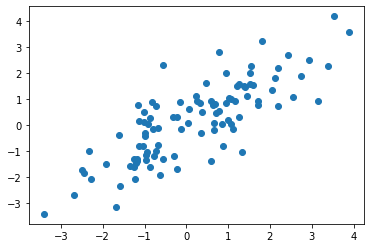

In [11]:
data = read_data("data/gaussian.txt")
plot_data(data)

$\q{2.1}$
By just looking at the plotted data, can you predict the direction of the first principal component? What about the second principal component?

$\ex{2.1}$
The principal components of a dataset can also be seen as the eigenvectors of the covariance
matrix. Compute the covariance matrix of the Gaussian dataset as follows:  
  
<center>$cov(X) = \dfrac{1}{N}(X - \bar{x})^\intercal(X - \bar{x})$  </center>

where $\bar{x}$ is the mean row of $N × D$ dimensional data matrix $X$. Next, compute the eigenvectors of this covariance matrix and plot the vectors accordingly.

In [12]:
def covariance(data):
    """
    This function computes the computes the covariance matrix of a given `data`.
    :param data: the starting data
    :return: the covariance matrix 
    """
    # -------------------------------Student ---------------------------------------
   
    # -------------------------------end Student ---------------------------------------
    return matrix


In [13]:
data = read_data("data/gaussian.txt")
matrix = covariance(data)

# You can check your implementation with the numpy built-in cov function.
# Your value might differ slightly as the numpy built-in cov function is a bit more precise than our function :).
matrix_np = np.cov(np.transpose(data))
err_msg="Your covariance matrix is allowed to be slight less precise but it should not differ more ~+-0.025"
np.testing.assert_allclose(matrix_np, matrix, atol=0.025, err_msg=err_msg)

NameError: name 'matrix' is not defined

In [14]:
# Use power iteration method to compute eigen vectors using your covariance matrix and plot the result.
# The plot should contain both the dataset (just like the previous one) and the eigen vectors.
# -------------------------------Student ---------------------------------------

# -------------------------------end Student ---------------------------------------

$\q{2.2}$ Which of these eigenvectors captures the most variance? Was this the first principal component or the second?

$\ex{2.2}$ Create a matrix object and let it read in `data/faces.txt`. This matrix is of size $N × D$, where $N$ is the number of images in the dataset and $D$ is the number of pixels per image (in this case 32 × 32, so D = 1024). Similar to before, compute the covariance matrix. Use this covariance matrix to compute the first 10 principal components and visualize them using numpy. Visualize the principal components using the given `create_image()` function.  
  
__Note__ `create_image()` only accepts rows of the dataset (`lists`), use the `transpose` function of `numpy` to convert columns to rows.

mean image


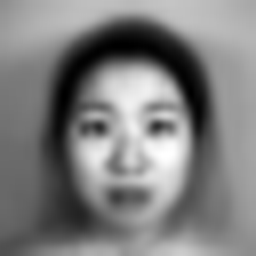

In [15]:
from IPython.display import display # to display images, usage: display(image)
data = read_data("data/faces.txt")
mean = np.mean(data, axis=0)

# Image of the mean
print("mean image")
mean_image = create_image(mean)
display(mean_image)
# Now plot the image of each of the eigenvectors of the given dataset
# -------------------------------Student ---------------------------------------

# -------------------------------end Student ---------------------------------------


$\q{2.3}$ What do these principal components mean, in terms of faces?
